<a href="https://colab.research.google.com/github/modestasgrz/P42-assessment/blob/main/Perfection42_AI_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolution genetic algorithm application for Super Mario Bros

Kaip naudoti šį kodą norint atkurti vaizdo medžiagoje matomus veiksmus:

Trumpai tariant: absoliučiai tiksliai atkurti vaizdo medžiagoje matomą scenarijų praktiškai neįmanoma. Nes parašytas algoritmas priverčia veikėją priimti sprendimus savarankiškai, įvertinant aplinkos kintamuosius ir savyje turi labai paprastą mechanizmą, kuris pagal aplinkybes kartais skatina atsitiktinį veikėjo elgesį (analogiškai RL algortimų 'exploration' sąvybei). Tačiau rezultatą (geresnį arba blogesnį) galima atkurti žemiau nuo 'Simulation Launch' skilties 'genome' laukelyje įvedus laiško prisegtuko archyvo tekstiniame faile pateiktą genomą (simbolių eilutės formatu, su tarpais, nukopijavus ir įklijavus). Ir tada paleidus visus Colab laukelius: 'Runtime > Run all'. Arba, jeigu jau skaičiavimai buvo leisti 'Runtime > Restart and run all'.

Kaip pakartoti tokio genomo paiešką:


Irgi, sutampanti genomą, su pateiktu faile, rasti praktiškai neįmanoma - teorinė tikimybė itin maža. 'Gerą' rezultatą pateikiantis genomas ieškomas jį generuojant atsitiktinai ir tikrinant veikėjo galimybes surinkti kuo didesnį atlygį (reward). Mažesnį, negu nustatyta, atlygį surinkęs genomas atmetamas. Genomo paiešką galima paleisti nuo 'Simulation Launch' laukelio. Tada reikia užkomentuoti 'Single launch' kodo celę, atkomentuoti 'Reward find loop' celę, nusistatyti 'reward_lower_bound' kintamojo reikšmę į minimalaus ieškomo atlygio vertę ir paleisti visas Colab celes.

Po paleidimo Colab apačioje matomas vaizdo įrašas, kaip Mario sekėsi žaisti su smegenimis, generuotomis iš surasto arba pateikto genomo. Šį vaizdo įrašą galima atsisiųsti iš /content/video/ aplankalo: 'rl-video-episode-0.mp4'. Genomą tekstiniame faile galima atsisiųsti iš /content/ aplankalo: 'genome.txt'.

## External downloads

In [ ]:
!pip install gym-super-mario-bros > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 
# !pip install numba > /dev/null 2>&1

## Imports and global functions

In [ ]:
import random
import numpy as np
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
import networkx as netx
import matplotlib.pyplot as plt
import gym
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from gym.wrappers import RecordVideo
# from numba import jit

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video', video_length=0)
    return env


def create_random_genome(num_genes):
  genome = []
  for _ in range(num_genes):
    gene = random.getrandbits(32)
    gene = format(gene, '08x')
    genome.append(gene)
  return genome

#'@jit
def launch_gameplay(genome, config):

  action_mappings = config.action_mappings
  env = gym_super_mario_bros.make('SuperMarioBros-v0', new_step_api=True) # Where is the documentation available for mario
  env = JoypadSpace(env, COMPLEX_MOVEMENT)

  env = wrap_env(env)
  observation = env.reset()

  # Actor creation
  actor = Actor(config=config, genome=genome)
  # actor.brain.display_brain()

  action_stats = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 0,
    5 : 0,
    6 : 0,
    7 : 0,
    8 : 0,
    9 : 0,
    10 : 0,
    11 : 0,
  } 
  overall_reward = 0
  # Whether to restart a game
  done = True
  noop_counter = 0
  # Looping through frames
  for step in range(2000):
      if done:
        # Start a game
        state = env.reset()
        next_action = 0
      # Do some actions in the game
      state, reward, done, info = env.step(next_action)
      next_action = actor(state=state, reward=reward, done=done, info=info)
      action_stats[next_action] = action_stats.get(next_action) + 1
      overall_reward += reward
      # Show the game on screen
      # env.render(mode='human') - render not available in google colab - video recording is being used
  # Close the game
  # env.close() - game is already closed ?

  # print action statistics
  actions_stats = np.array([("-".join(action_mappings.get(key)), value) for (key, value) in action_stats.items()])
  # print(actions_stats)
  # print(f"Overall reward {overall_reward}")
  return actions_stats, overall_reward

## Config

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
  num_inner_neurons = 30
  num_sensory_neurons = 18
  num_action_neurons = 12
  num_genes = 256
  sense_neurons_mapping = {
    'SN_0':'state_0',
    'SN_1':'state_1',
    'SN_2':'state_2',
    'SN_3':'state_3',
    'SN_4':'state_4',
    'SN_5':'reward',
    'SN_6':'reward',
    'SN_7':'reward',
    'SN_8':'coins',
    'SN_9':'coins',
    'SN_10':'flag_get',
    'SN_11':'flag_get',
    'SN_12':'life',
    'SN_13':'score',
    'SN_14':'status',
    'SN_15':'time',
    'SN_16':'x_pos',
    'SN_17':'y_pos',
  }
  action_mappings = {
      0 : ['NOOP'],
      1 : ['right'],
      2 : ['right', 'A'],
      3 : ['right', 'B'],
      4 : ['right', 'A', 'B'],
      5 : ['A'],
      6 : ['left'],
      7 : ['left', 'A'],
      8 : ['left', 'B'],
      9 : ['left', 'A', 'B'],
      10 : ['down'],
      11 : ['up'],
  }

config = Config()

## Evolution genetic algorithm classes

### Actor (agent) class

In [ ]:
class Actor():
  def __init__(self, config, genome=None):
    self.genome = genome
    self.brain = Brain(genome, config)
    self.state_feature_extractor = None # CNN not yet implemented

    self.near_past_rewards = []

  def __call__(self, state, reward, done, info, truncated=False):
    sense_input = info
    sense_input['reward'] = reward
    sense_input['done'] = done
    if self.state_feature_extractor:
      state_encodings = self.state_feature_extractor(state)
    else:
      state_encodings = [0.0, 0.0, 0.0, 0.0, 0.0] # Disregard state values if state encoder not implemented
    sense_input['state_0'] = state_encodings[0]
    sense_input['state_1'] = state_encodings[0]
    sense_input['state_2'] = state_encodings[0]
    sense_input['state_3'] = state_encodings[0]
    sense_input['state_4'] = state_encodings[0]    
    
    action = self.brain(sense_input)

    # Simple nudge to the actor to do something more about the reward, if it continues to decline
    past_acc_reward = sum(self.near_past_rewards)
    self.near_past_rewards.append(reward)
    if len(self.near_past_rewards) > 10:
      self.near_past_rewards.pop(0)
      present_acc_reward = sum(self.near_past_rewards)
      if present_acc_reward <= past_acc_reward:
        action = random.randint(0, 11)

    return action

### Neuron classes

In [ ]:
class SensorNeuron():
  # Activation function produces value from 0.0 to 1.0
  # in regards to the input and neuron's type
  #
  def __init__(self, type_id):
    self.type_id = type_id
    self.activation = {
        0 : self.state, # SN_0 - state sensory neuron
        1 : self.state, # SN_1 - state sensory neuron
        2 : self.state, # SN_2 - state sensory neuron
        3 : self.state, # SN_3 - state sensory neuron
        4 : self.state, # SN_4 - state sensory neuron
        5 : self.reward, # SN_6 - reward sensory neuron
        6 : self.reward, # SN_7 - reward sensory neuron
        7 : self.reward, # SN_8 - reward sensory neuron
        8 : self.coins, # SN_9 - coins sensory neuron
        9 : self.coins, # SN_10 - coins sensory neuron
        10 : self.flag_get, # SN_11 - flag get sensory neuron
        11 : self.flag_get, # SN_12 - flag get sensory neuron
        12 : self.life, # SN_13 - life sensory neuron
        13 : self.score, # SN_14 - score sensory neuron
        14 : self.status, # SN_16 - status sensory neuron
        15 : self.time, # SN_17 - time sensory neuron
        16 : self.x_pos, # SN_18 - x position sensory neuron
        17 : self.y_pos, # SN_19 - y position sensory neuron
    }.get(type_id, self.no_action)

  def __str__(self):
    return f"SN_{self.type_id}"

  def __call__(self, x, weight):
    #return self.activation(x) * weight
    return self.activation(x) * weight
  
  def state(self, x):
    return x # If x - stadartized and normalized, will need to use softmax on state extraction nn

  def reward(self, x):
    # reward is clipped into range (-15; 15)
    # making reward <- (0; 1) (regarding algorithm implementation video "sensory neurons provide value in a range (0; 1)")
    return (x + 15.0) / 30.0

  def coins(self, x):
    # According to some unverified sources on internet - hard limit on coins that Mario can hold = 9999
    # This number is used normalizing coins input, assuming that coin value can be in range (0; 9999)
    return (x / 9999.0)

  def flag_get(self, x):
    # Flag value is either True (= 1) or False (= 0)
    if x:
      return 1.0
    else:
      return 0.0

  def life(self, x):
    # Maximum number of available lifes is a member of {3; 2; 1}
    # Normalizing out of 3
    return (x / 3.0)

  def score(self, x):
    # According to https://www.youtube.com/watch?v=Pnu72O4PREE&t=355s
    # The highest score on Mario = 3,663,400 - should score value be standartized by this super high number?
    # My concern is, whether this activation has any significant influece on the output of the network,
    # when using this standartization
    return (x / 3663400.0)

  def status(self, x):
    # Mario's status, i.e., {'small', 'tall', 'fireball'}
    # 'tall' - better than small, fireball, I assume, as well
    if x == 'small':
      return 0.0
    elif x == 'tall':
      return 1.0
    else:
      return 1.0

  def time(self, x):
    # Time starts at 400
    return (x / 400.0)

  def x_pos(self, x):
    # Without glitching through game mechanics, the maximum x could be 700 (very hardly of course)
    return (x / 700.0)

  def y_pos(self, x):
    # Without glitching through game mechanics, the maximum y could be 400 (very hardly of course)
    return (x / 400.0)

  def no_action(self, x):
    # No action selected for this neuron - action unindentified
    return 0.0


class InnerNeuron(): 
  # Simple standard neuron - perceptron
  def __init__(self, type_id):
    self.type_id = type_id

  def __str__(self):
    return f"IN_{self.type_id}"

  def __call__(self, x, weight):
    # Here x is considered to be a list of values
    return np.tanh(sum(x)) * weight

  

class ActionNeuron():
  # Action neuron should provide the number of an action they trying to invoke
  # This number at init matches neuron's type_id
  #
  # However, the dictionary of actions is presented here
  #
  # self.action = { # 4 bits are enough
  #       0 : ['NOOP'],
  #       1 : ['right'],
  #       2 : ['right', 'A'],
  #       3 : ['right', 'B'],
  #       4 : ['right', 'A', 'B'],
  #       5 : ['A'],
  #       6 : ['left'],
  #       7 : ['left', 'A'],
  #       8 : ['left', 'B'],
  #       9 : ['left', 'A', 'B'],
  #       10 : ['down'],
  #       11 : ['up'],
  #   }
  #
  # self.__call__() method calculates the outcome of inputs, but does not activate the action
  #
  # Action is activated, when particular neuron is selected in brain
  # by taking this neuron and calling self.activate() method on it
  # self.activate() simply provides the number of the selected action
  # which matches type_id of the neuron
  #
  # So, this neuron is a simple perceptron with additional, task-related, activate feature
  #
  def __init__(self, type_id):
    self.type_id = type_id

  def __str__(self):
    return f"AN_{self.type_id}"

  def __call__(self, x):
    return np.tanh(sum(x))
  
  def activate(self):
    return self.type_id

### Brain class

In [ ]:
class Brain(): # Directional graph
  def __init__(self, genome, config):
    self.connections = self.read_genome(genome, config.num_sensory_neurons, config.num_inner_neurons, config.num_action_neurons)
    self.connections = self.remove_redundant_connections(self.connections)
    self.brain = self.make_brain_dictionary(self.connections)
    self.sense_neurons_mapping = config.sense_neurons_mapping

  def __str__(self):
    str_brain = "{" + "\n"
    for key, value in self.brain.items():
      str_connections = "{ \n"
      for neuron, weight in value.items():
        str_connections += "             " + str(neuron) + " :  " + str(weight) + ", \n"
      str_connections += "          }"
      str_brain += f"   {str(key)} : {str_connections}" + "\n"
    str_brain += "}"
    return str_brain
  
  # def forward(self, x): here initial x - dictionary of sense input values mapping
  def __call__(self, sense_input): # functionality - debug this

    # This is the where calculated values are accumulated
    activated_sinks = []
    x = 0.0
    # Sensory Neurons activation
    # Find Sensory Neurons and calculate activations,
    # Then append them to the activated_sinks list
    for source, sinks in self.brain.items():
      if "SN" in str(source):
        for sink, weight in sinks.items():
          activation_input_type = self.sense_neurons_mapping.get(str(source), "") # Default get value = ""
          x = sense_input.get(activation_input_type, 0.0) # Default get value = 0.0
          x = source(x, weight)
          activated_sinks.append((sink, x))

    # print("ACTIVATED SINKS (IN):")
    # print(np.array([(str(sink), value) for (sink, value) in activated_sinks]))
    # print("")

    # Inner Neurons activation
    # Find some Inner Neuron
    for new_source, new_x in activated_sinks:
      if "IN" in str(new_source):
        current_in = str(new_source)
        # For every activation assigned to the chosen Inner Neuron collect input
        in_input = [] 
        for source, x in activated_sinks:
          if str(source) == current_in:
            in_input.append(x)
        # Remove registered activation from the list - filter list, so it could not interfere with later runs
        activated_sinks = [(node, activation) for (node, activation) in activated_sinks if str(node) != current_in]
        # Now determine, to which new sinks assign this activation, if input exists
        if len(in_input) > 0:
          for source, sinks in self.brain.items():
            if current_in == str(source):
              # Calculate and assign new activations
              for sink, weight in sinks.items():
                x = source(in_input, weight)
                activated_sinks.append((sink, x))

    # print("ACTIVATED SINKS (AN):")
    # print(np.array([(str(sink), value) for (sink, value) in activated_sinks]))
    # print("")

    # Action Neurons activation
    # First declare output activations list
    output_activations = []
    # Find some Action Neuron - begining analogous to IN activation
    for new_source, new_x in activated_sinks:
      if "AN" in str(new_source):
        current_an = str(new_source)
        # For every activation assigned to the chosen Action Neuron collect input
        an_input = [] 
        for source, x in activated_sinks:
          if str(source) == current_an:
            an_input.append(x)
        # Remove registered activation from the list - filter list, so it could not interfere with later runs
        activated_sinks = [(node, activation) for (node, activation) in activated_sinks if str(node) != current_an]
        # Now calculate activations for every action neuron and put them in a list, if inputs exist
        if len(an_input) > 0:
          x = new_source(an_input)
          output_activations.append((new_source, x))

    # print("OUTPUT ACTIONS (AN):")
    # print(np.array([(str(sink), value) for (sink, value) in output_activations]))
    # print("")

    # Find index of the action neuron having the largest activation
    _, an_index = np.argmax(np.array([(str(sink), value) for (sink, value) in output_activations]), axis=0)

    # Formulate output
    output = output_activations[an_index] # (action_neuron, activation)
    action_neuron, activation = output
    # print("SELECTED ACTION NEURON: " + str(action_neuron) + ", WITH ACTIVATION: " + str(activation))
    return action_neuron.activate() # Provides number of in-game action - neuron's type id

  def display_brain(self):
    self.brain_graph = netx.DiGraph()
    str_connections = [(str(source_neuron), str(sink_neuron), round(weight, 2)) for source_neuron, sink_neuron, weight in self.connections]
    self.brain_graph.add_weighted_edges_from(str_connections)
    colors = {}
    for node in self.brain_graph.nodes():
      if "SN" in node: # Sensory Neuron
        colors[node] = "blue"
      elif "IN" in node: # Inner Neuron
        colors[node] = "grey"
      else:
        colors[node] = "red"
    weight_labels = netx.get_edge_attributes(self.brain_graph, 'weight')
    node_labels = {node:node for node in self.brain_graph.nodes()}
    # Spring layout - appealing to the eye layout of a graph, required for draw function
    pos = netx.spring_layout(self.brain_graph)
    # netx.draw(self.brain_graph, with_labels=True)
    netx.draw_networkx_nodes(self.brain_graph, pos, node_color=[colors.get(node, "gray") for node in self.brain_graph.nodes()], alpha=0.3)
    netx.draw_networkx_edges(self.brain_graph, pos)
    netx.draw_networkx_edge_labels(self.brain_graph, pos, edge_labels=weight_labels)
    netx.draw_networkx_labels(self.brain_graph, pos, labels=node_labels, font_size=10)
    plt.show()
  
  def make_brain_dictionary(self, connections): # make brain graph
    brain = {}
    for i, connection in enumerate(connections):
      source_neuron, sink_neuron, weight = connection
      appended = False
      for existing_neuron in brain.keys():
        if source_neuron.type_id == existing_neuron.type_id and str(source_neuron) == str(existing_neuron):
          # Appends sink neuron to existing source neuron key

          # Every neuron at init stage is assigned with a different reference,
          # but neurons with the same type and id should match in reference
          # as they are the same one neuron
          source_neuron = existing_neuron
          brain[source_neuron].append((sink_neuron, weight))
          appended = True
          break
      if not appended:
        # Adds new source neuron and corresponding sink neuron to it
        brain[source_neuron] = [(sink_neuron, weight)]
    for key, value in brain.items():
      # Switching lists in values instead of dictionaries
      brain[key] = {sink_neuron : weight for sink_neuron, weight in brain[key]}
    
    return brain

  def remove_redundant_connections(self, connections):
    # Make neuron list with num_inputs and num_outputs
    neuron_list = [] # (neuron, num_inputs, num_outputs)
    # print(np.array([(str(source), str(sink), weight) for (source, sink, weight) in connections]))
    # print("")
    for source, sink, weight in connections:
      if str(source) == str(sink):
        # Illegal connection - remove imediately
        connections.remove((source, sink, weight))
      source_updated = False
      sink_updated = False
      for i, item in enumerate(neuron_list):
        neuron, num_inputs, num_outputs = item
        if str(source) == str(neuron):
          neuron_list[i] = (neuron, (num_inputs + 1), num_outputs)
          source_updated = True
        if str(sink) == str(neuron):
          neuron_list[i] = (neuron, num_inputs, (num_outputs + 1))
          sink_updated = True
      if not source_updated:
        neuron_list.append((source, 1, 0))
      if not sink_updated:
        neuron_list.append((sink, 0, 1))
    
    # Find redundant neurons
    # Redundant neurons - INs with 0 inputs OR 0 outputs are redundant - connections with them will be removed - names of the neurons
    redundant_neurons = [str(neuron) for (neuron, num_inputs, num_outputs) in neuron_list 
                         if "IN" in str(neuron) and (num_inputs == 0 or num_outputs == 0)]

    # Remove them from connections - filter connections
    connections = [(source, sink, weight) for (source, sink, weight) in connections 
                   if (not str(source) in redundant_neurons) and (not str(sink) in redundant_neurons)]
    
    # print(np.array([(str(source), str(sink), weight) for (source, sink, weight) in connections]))
    # print("")
    # print(np.array([neuron for neuron in redundant_neurons]))
    return connections

  def read_gene(self, gene, num_sensory_neurons, num_inner_neurons, num_action_neurons):
    # Hex string to Bin string
    gene = format(int(gene, 16), '032b')

    # Parse encoded parameters from bits
    # Source Type: 0 - sensory neuron; 1 - inner neuron
    source_type = gene[0]
    source_type = int(source_type, 2)

    # Source ID: type id of the source neuron (without modulus applied)
    source_id = gene[1:8]
    source_id = int(source_id, 2)

    # Sink Type: 0 - action neuron; 1 - inner neuron
    sink_type = gene[8]
    sink_type = int(sink_type, 2)
    # NEW RULE: Inner Neurons cannot connect to themselves or each other
    if source_type == 1:
      sink_type = 0

    # Sink ID: type id of the sink neuron (without modulus applied)
    sink_id = gene[9:16]
    sink_id = int(sink_id, 2)

    # Weight: weight of the connection <- [-5 ... 5]
    weight = gene[16:]
    weight = (((int(weight, 2) / int("ffff", 16)) - 0.5) * 2) * 5 # [-5 .. 5]

    if source_type == 1: # Inner neuron
      source_id = source_id % num_inner_neurons
      source_neuron = InnerNeuron(type_id=source_id)
    elif source_type == 0: # Sensor neuron
      source_id = source_id % num_sensory_neurons
      source_neuron = SensorNeuron(type_id=source_id)

    if sink_type == 1: # Inner neuron
      sink_id = sink_id % num_inner_neurons
      sink_neuron = InnerNeuron(type_id=sink_id)
    elif sink_type == 0: # Action neuron
      sink_id = sink_id % num_action_neurons
      sink_neuron = ActionNeuron(type_id=sink_id)

    return source_neuron, sink_neuron, weight

  def read_genome(self, genome, num_sensory_neurons, num_inner_neurons, num_action_neurons):
    return [self.read_gene(gene, num_sensory_neurons, num_inner_neurons, num_action_neurons) for gene in genome]


## Simulation Launch

Paste the genome below (to variable's 'genome' value) to generate brain wiring from it and launch game with it

In [ ]:
genome = "f8bd032a 19acca6c db6294e2 07c70cd5 25894198 43c244c9 99d88552 7c3e374a ac011d35 e2df6b90 9b81d3fe cfb8f690 9d1a9847 e3533d2f 8049b9cb 35dffd13 7569ec7b c0dd8ff5 242d97ac c8de7563 35919376 3d346713 9faad7cd be45773f 0bc14f98 088e26ac c1ab3f04 369806fe c01f2e3c 41cd2347 437ce986 6a54d103 3e8d5426 a25c4ea5 f923ddb5 526cb622 6a8de9b8 ecf07100 2eb06d53 988289e8 6219a85c b3d399ca 5fbaff33 3362db58 c5a79f44 f1fc2db6 373045a3 8304a225 a98add65 96172645 2d6c726b 1b95f1f5 c9d45aec 759e02ca 5fbb85c3 46e126b1 eea3377c 90e98bd3 a8f32adb ba843fd2 07579842 cc537013 07b4c613 e6d435e4 2455c311 de6bed17 3968e6a3 6d072ade d29358cf 25dd6073 b8d1ba7c d8d8fd5b cd40b816 f5e8c57e 07da9e5f 363d5c60 42225404 19d5e49c 6576bd74 ddb73020 5e33343b f319809b ce9791d5 b202c960 4bc60780 af0a01a4 b67694db 1f375b91 19dd9e1e 8faa85de 8d5b93e5 ff467d0c 32632df0 460a4e15 a66bcfb9 287b0082 16038d8a 093c0c74 6e17f942 1016ada9 f5453eb5 94cdc5d5 fbdca83c ac5e22a8 f1391eae f86b0551 ebc593c9 25afc61d b4f23c81 90f8224a 668e33ef c8d60d64 3f72b91f f78ede1f 51c92865 39bd9d0f bb4fadf8 df6c218d 3b227f9d 51fc8112 3402683f 5ccce444 dc1d9be8 da163bf6 ecea734b 7d335148 465f0466 ef590841 3676354a 8b04adae e921c036 878a8e50 823f572d 77346981 bc77cbf7 c8155d6a e83a6994 03856490 7f338634 7916ea45 0ac8a298 ee59ece4 eb93b3a3 df5bf92a 211680ca f2887ca2 abac0b07 c17c2c14 b420e85a 91ea22a2 0f649d27 45097335 ada1996d e542bfa5 a0b4aaee b318091a 72119cc9 cef3d565 985c42a3 2bca7f88 ab854b08 a97c48e6 b6e5a5ad 957da535 5507cad3 f9cc9456 f9a2032b d99935e8 ec0e4435 f13a0e36 51e11f70 80c9508b f6c0fe20 ad137119 70eb6cac 65142a00 e78368c7 eaef4b2b d3be87a8 94e8f2df 76721bdd d1be498d d33cc10f ba3652b5 4f72223f e36e8d16 a6eb4741 731428b3 891ba45b d6c37356 e2746e37 cd577366 5bfcd78a 3f0888c8 200e6b35 9fe76b57 c59df16b 898dbf89 9cb2a522 7650100b f376cddc a4e81073 45979409 88bb9c74 f66fda3f 6e37098a 8f3b1e59 70eff3fd 70b694b8 9486a770 40d7ed97 9bf48d27 8bbbfafe 0cf2064e c257ede9 5a1784de b98cde09 3e9a45b2 63ffc425 4a52561e 33b3a430 9f6519b1 ac4d8e8d 23353e88 15974b24 91bc1acd 83d38c40 e05490f6 a9254fda 8ba4b70e 90284483 2788ff6b d03a329c fed1814c 54d38355 9074a19a 115281e6 ff0f9447 a93abd70 36fa1381 0923e38a 5f1fa442 e2db0950 fcb32f25 78649c59 f8693f45 b2567c0b a6e27393 51ca01dc dce7a16f 2a84ad2c d2cfcf57 56285acc d4d55345 1337a7aa 0ee272c8"

In [ ]:
# Single launch

if genome is None or genome == "":
  genome = create_random_genome(config.num_genes)
else:
  genome = genome.split()

action_stats, overall_reward = launch_gameplay(genome, config)
print(action_stats)
print(f"Overall reward collected: {overall_reward}")
with open("/content/genome.txt", "w+") as file:
    file.write(" ".join(genome))

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:67: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pul

[['NOOP' '112']
 ['right' '124']
 ['right-A' '123']
 ['right-B' '130']
 ['right-A-B' '552']
 ['A' '128']
 ['left' '143']
 ['left-A' '128']
 ['left-B' '128']
 ['left-A-B' '164']
 ['down' '129']
 ['up' '139']]
Overall reward collected: 437.0


Uncomment the loop below to start findings for a genome, using which actor collects at least the selected amount of a overall reward. Change variable's 'reward_lower_bound' value to search for a better or worse genome. Higher values - better performace in a game - better genome, but longer search. The below cell runs undetermined amount of time.

In [ ]:
# # Reward find loop
# # Uncomment this to launch the worst computationally, but working algorithm
# # for best suited genome findings - genomes will be generated randomly
# # and tested in game environment by collecting the reward

# reward_lower_bound = 500

# overall_reward = 0
# while overall_reward < reward_lower_bound:
#   genome = create_random_genome(config.num_genes)
#   action_stats, overall_reward = launch_gameplay(genome, config)

# print(action_stats)
# print(f"Best found overall reward: {overall_reward}")

# with open("/content/genome.txt", "w+") as file:
#     file.write(" ".join(genome))

## Video review

In [ ]:
# This enivronment reset is needed for the video to be displayed (for some unknown reason)
# At it cannot be done in the same cell

env = gym_super_mario_bros.make('SuperMarioBros-v0', new_step_api=True)
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [ ]:
show_video()

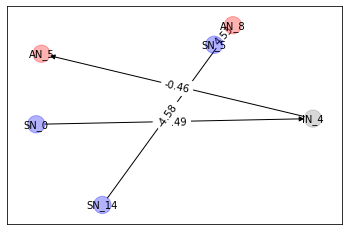

In [ ]:
actor = Actor(config=config, genome=create_random_genome(8))
actor.brain.display_brain()

Selection criteria is needed - automated solution finding